In [1]:
import yfinance as yf 
import pandas as pd
from matplotlib import pylab as plt
import numpy as np
from datetime import datetime
import pytz

import quandl

import seaborn as sns

import sys

In [2]:
def port_eval(port, freq = 'D'):
    
    port = pd.DataFrame(port)
    port_ret = calc_port_ret(port)
    vol = np.log(port_ret).std()*np.sqrt(252)
    
    Roll_Max = port.cummax()
    Daily_Drawdown = port/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    Max_Daily_Drawdown = Max_Daily_Drawdown.tail(1)
    
    neg_ret = port_ret[port_ret<1].dropna()
    sortino = np.log(neg_ret).std()*np.sqrt(252)
    
    if freq == 'D':
        cagr = port_ret.cumprod().tail(1)**(252/len(port_ret)) - 1
        MAR = cagr/Max_Daily_Drawdown
        
    elif freq == 'M':
        cagr = port_ret.cumprod().tail(1)**(12/len(port_ret)) - 1
        MAR = cagr/Max_Daily_Drawdown
    
    metrics = pd.DataFrame({'': [float(cagr.iloc[0]), float(vol.iloc[0]), float(sortino.iloc[0]),
                                   float(Max_Daily_Drawdown.iloc[0])]},
                   index=['CAGR', 'Volatility', 'Sortino', 'Mad DD'])
    
    metrics = round(metrics*100, 2)
    metrics = metrics.astype(str) + '%'
    
    return metrics 

In [3]:
def calc_port_ret(port):
    port_ret = port/port.shift(1)
    port_ret = port_ret.fillna(1)
    
    return port_ret

In [4]:
def backtest_strategy(data, W, tol, rebalance_freq, data_names):
    initial = 1
    asset = [i * initial for i in W]
    port = []
    port_W = [] 

    if sum(W) == 1:

        for i in range(len(data)):
            port.append(initial)
            port_W.append([i / initial for i in asset])
        
            asset = asset * data.iloc[i]
            initial = sum(asset)
        
            #Rebalancing by days
            if i%rebalance_freq == 0:
                for i in range(len(W)):
                    asset[i] = initial * W[i]
            
            #Rebalancing by deviation
            for i in range(len(asset)):
                if abs(asset[i]/initial - W[i])> tol:  
                      asset = [i * initial for i in W]
    
        port = pd.DataFrame(port)
        port.index = data.index
    
        result = pd.concat([port, data.cumprod()], axis =1)
        result.columns = ["Portfolio"] + data_names
        
        return (result)
        
    else:
        print("Weight not Equal to 1!")

# Backtesting Portfolio

TODO:
- 

In [5]:
asset_1_tmp = yf.download("^GSPC")
#asset_2_tmp = yf.download("^VIX")
asset_3_tmp = yf.download("SHY")
asset_4_tmp =  yf.download("TLT")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
asset_2_tmp = quandl.get("LBMA/GOLD", authtoken="6rNSyTM5R4g7_B7XSyQW")

In [7]:
data_imp = pd.read_excel (r'https://www.eurekahedge.com/Indices/ExportIndexReturnsToExcel?IndexType=Eurekahedge&IndexId=640')

In [21]:
asset_1 = asset_1_tmp['Close']
asset_2 = asset_2_tmp["USD (AM)"]
asset_3 = asset_3_tmp['Close']
asset_4 = asset_4_tmp['Close']

In [22]:
data = pd.concat([asset_1, asset_2, asset_4], axis = 1) #asset_2, asset_4
data = data.ffill()
data = data.dropna()
data = data/data.shift(1)
data = data.fillna(1)

data_names = ['SPY','Gold' ,'Bonds'] #,'Gold' ,'Bonds'
data.columns = data_names

In [24]:
data = pd.concat([asset_1, asset_2, asset_4], axis = 1)
data = data.ffill()
data = data.dropna()
monthly_data = data.resample('M').first()
monthly_data.index=monthly_data.index.map(lambda x : x.replace(day=1))

long_vol = data_imp[3:]
long_vol.index= pd.to_datetime(data_imp[3:]['Unnamed: 0'])
long_vol = pd.DataFrame(long_vol['Unnamed: 2'])


monthly_data = pd.concat([monthly_data, long_vol], axis=1)
monthly_data = monthly_data.ffill()
monthly_data = monthly_data.dropna()
monthly_data.columns = data_names + ["Long Vol"]
monthly_data = monthly_data/monthly_data.shift()
monthly_data = monthly_data.fillna(1)

In [26]:
rebalance_freq = 120
tol = 0.10
W = [0.25, 0.25, 0.25, 0.25]

data_names = ['SPY','Gold' ,'Bonds'] + ["Long Vol"]


result = backtest_strategy(monthly_data, W, tol, rebalance_freq, data_names)

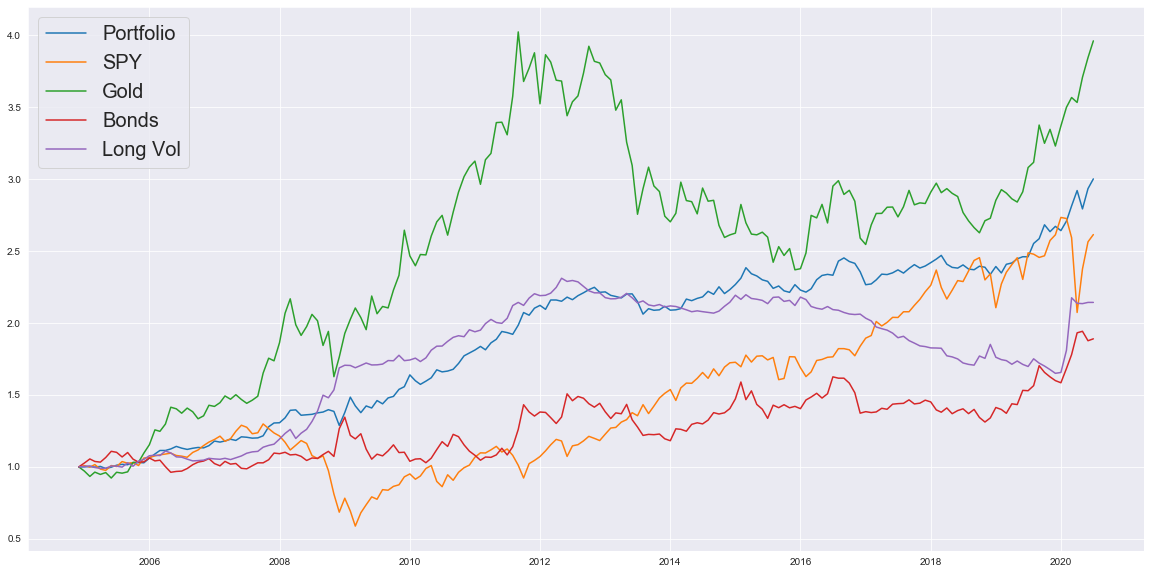

In [27]:
sns.set_style("darkgrid")
plt.figure(figsize=(20,10))
for i in result.columns:
    plt.plot(result[i], label = i);

plt.legend(loc=2, prop={'size': 20});


In [18]:
metrics = pd.DataFrame([])
for i in result.columns:
    metrics = pd.concat([metrics, port_eval(result[i], freq = 'D')], axis = 1)
metrics.columns = ["Portfolio"] + data_names

In [19]:
metrics

,Portfolio,SPY,Gold,Bonds
CAGR,7.79%,7.18%,10.2%,3.96%
Volatility,11.1%,19.43%,17.73%,13.84%
Sortino,8.89%,16.59%,13.3%,9.61%
Mad DD,-32.0%,-56.78%,-44.6%,-28.46%
